In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = get_BJ_time()
print(current_time)

0901_16-45-51


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
df_2019_cv = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
bs = 32 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# Training (Transfer learning)
The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [7]:
def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

## Fold 1

In [8]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid1")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b3_0901_03-31-49_stage1")
print("Reload stage1 model")

Loaded pretrained weights for efficientnet-b3
Reload stage1 model


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


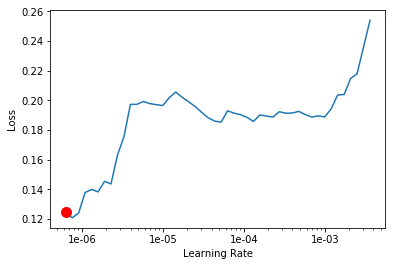

In [15]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [16]:
model_save_name = "{}_{}_stage2_f1".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.174309,0.215754,0.914902,00:24
1,0.194766,0.217427,0.910209,00:24
2,0.189688,0.218218,0.911894,00:24
3,0.201021,0.218246,0.910874,00:24


Better model found at epoch 0 with valid_loss value: 0.21575413644313812.
Epoch 4: early stopping
Model save as: efficientnet-b3_0901_16-45-51_stage2_f1


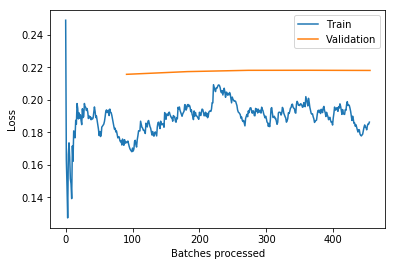

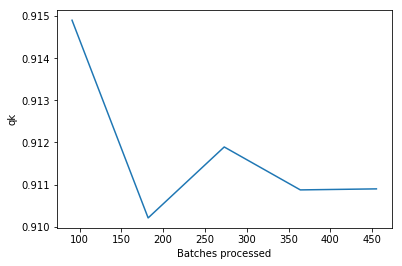

In [17]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [18]:
learn.load(model_save_name)
print("Reload", model_save_name)

Reload efficientnet-b3_0901_16-45-51_stage2_f1


## Fold 2

In [20]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid2")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b3_0901_03-31-49_stage1")
print("Reload stage1 model")

Loaded pretrained weights for efficientnet-b3
Reload stage1 model


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-07


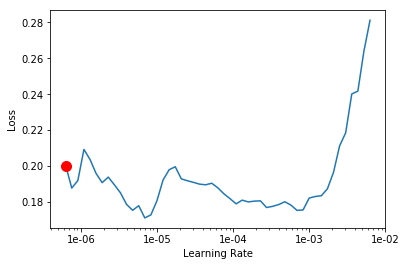

In [26]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [27]:
model_save_name = "{}_{}_stage2_f2".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 3e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.181005,0.200695,0.901204,00:24
1,0.179247,0.201257,0.901269,00:24
2,0.176989,0.201248,0.900760,00:24
3,0.176912,0.200754,0.901269,00:24


Better model found at epoch 0 with valid_loss value: 0.20069479942321777.
Epoch 4: early stopping
Model save as: efficientnet-b3_0901_16-45-51_stage2_f2


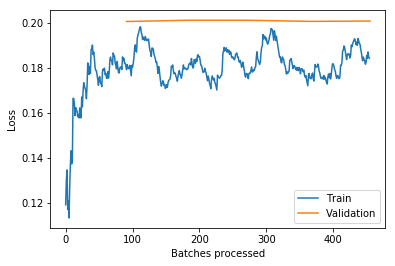

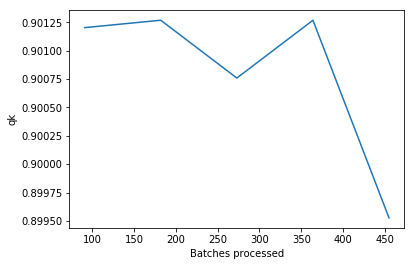

In [28]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [29]:
learn.load(model_save_name)
print("Reload", model_save_name)

Reload efficientnet-b3_0901_16-45-51_stage2_f2


## Fold 3

In [31]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid3")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b3_0901_03-31-49_stage1")
print("Reload stage1 model")

Loaded pretrained weights for efficientnet-b3
Reload stage1 model


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-06


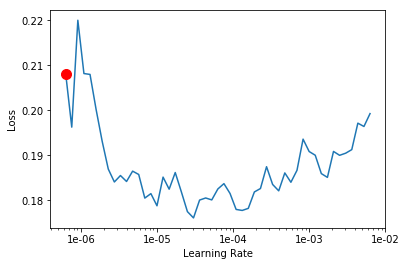

In [37]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [38]:
model_save_name = "{}_{}_stage2_f3".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 2e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.161738,0.213493,0.880151,00:24
1,0.155326,0.213302,0.879846,00:24
2,0.169742,0.213150,0.880157,00:24
3,0.172757,0.213149,0.880473,00:24
4,0.178864,0.213601,0.880193,00:24
5,0.170515,0.213141,0.880022,00:24
6,0.163400,0.213163,0.880022,00:24
7,0.172573,0.212913,0.881305,00:24
8,0.169627,0.213014,0.881305,00:24
9,0.161224,0.213022,0.881305,00:24


Better model found at epoch 0 with valid_loss value: 0.213493213057518.
Better model found at epoch 1 with valid_loss value: 0.21330159902572632.
Better model found at epoch 2 with valid_loss value: 0.213149756193161.
Better model found at epoch 3 with valid_loss value: 0.21314914524555206.
Better model found at epoch 5 with valid_loss value: 0.21314121782779694.
Better model found at epoch 7 with valid_loss value: 0.21291275322437286.
Epoch 11: early stopping
Model save as: efficientnet-b3_0901_16-45-51_stage2_f3


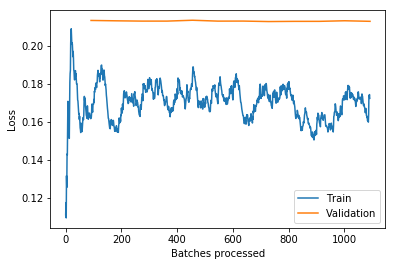

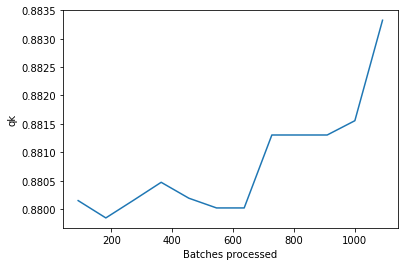

In [39]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [40]:
learn.load(model_save_name)
print("Reload", model_save_name)

Reload efficientnet-b3_0901_16-45-51_stage2_f3


## Fold 4

In [81]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid4")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b3_0901_03-31-49_stage1")
print("Reload stage1 model")

Loaded pretrained weights for efficientnet-b3
Reload stage1 model


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 5.75E-07


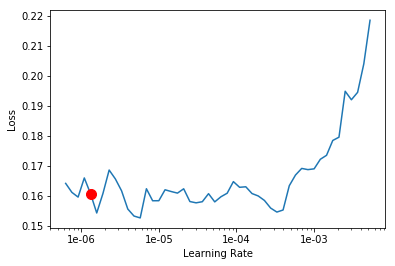

In [59]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage2_f4".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

In [83]:
learn.validate()

[0.2066468, tensor(0.9023)]

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.load(model_save_name)
print("Reload", model_save_name)

## Fold 5

In [68]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid5")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b3_0901_03-31-49_stage1")
print("Reload stage1 model")

Loaded pretrained weights for efficientnet-b3
Reload stage1 model


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 6.31E-08


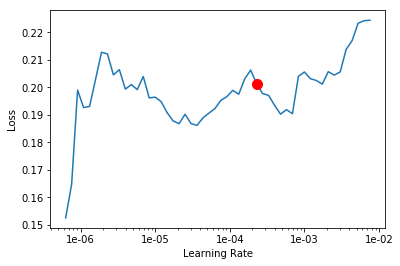

In [76]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [77]:
model_save_name = "{}_{}_stage2_f5".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.183477,0.223962,0.880458,00:24
1,0.171524,0.225067,0.880458,00:24
2,0.183778,0.225605,0.882283,00:24
3,0.178163,0.226107,0.882056,00:24


Better model found at epoch 0 with valid_loss value: 0.22396241128444672.
Epoch 4: early stopping
Model save as: efficientnet-b3_0901_16-45-51_stage2_f5


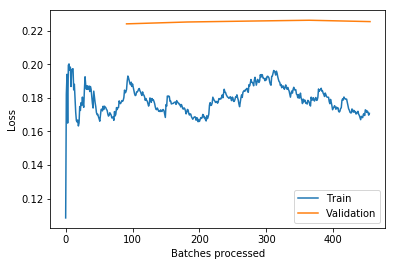

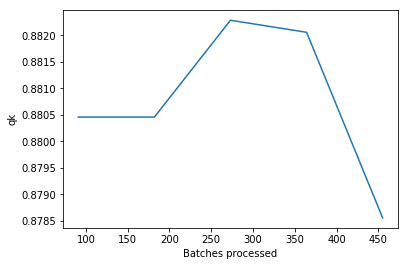

In [78]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [79]:
learn.load(model_save_name)
print("Reload", model_save_name)

Reload efficientnet-b3_0901_16-45-51_stage2_f5


# Submission

## Fold 1

efficientnet-b3_0901_16-45-51_stage2_f1.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5fdbbb978>]], dtype=object)

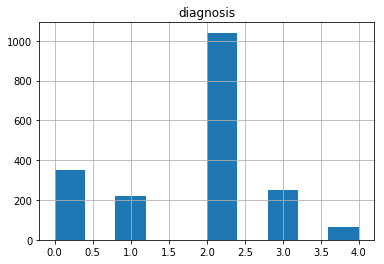

In [19]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)
save_filename = '../output/submission/{}.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')
test_df.hist()

## Fold 2

efficientnet-b3_0901_16-45-51_stage2_f2.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5ccd055f8>]], dtype=object)

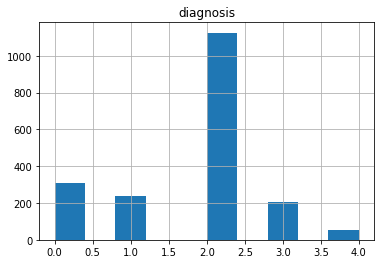

In [30]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)
save_filename = '../output/submission/{}.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')
test_df.hist()

## Fold 3

efficientnet-b3_0901_16-45-51_stage2_f3.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5fda534a8>]], dtype=object)

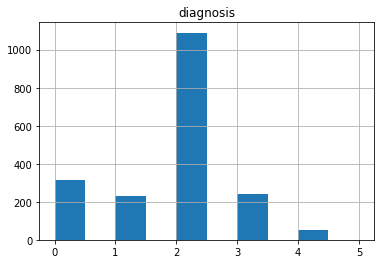

In [41]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)
save_filename = '../output/submission/{}.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')
test_df.hist()

## Fold 4

efficientnet-b3_0901_16-45-51_stage2_f4.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5fd9e8a20>]], dtype=object)

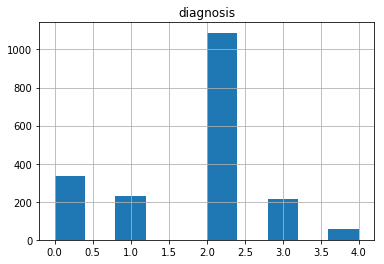

In [52]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)
save_filename = '../output/submission/{}.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')
test_df.hist()

## Fold 5

../output/submission/efficientnet-b3_0901_16-45-51_stage2_f5.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5cc87fcc0>]], dtype=object)

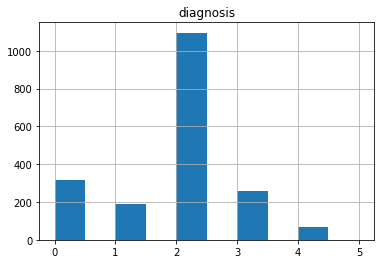

In [80]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)
save_filename = '../output/submission/{}.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')
test_df.hist()